In [1]:
from Imports import *
from Helper import *
from Preprocessing import *
from Plotting import *

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.3)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([87266, 16, 16])
dR Mean: torch.Size([87266])
dR STD: torch.Size([87266])
Pixel Mean: torch.Size([87266])
Pixel STD: torch.Size([87266])
ΔR min: 0.0
ΔR max: 2.203810453414917
ΔR mean min: 0.003941118251532316
ΔR mean max: 0.0156550332903862
ΔR std min: 0.020212490111589432
ΔR std max: 0.14540068805217743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.00432002916932106
Pixel std min: 0.009188652969896793
Pixel std max: 0.06249340996146202


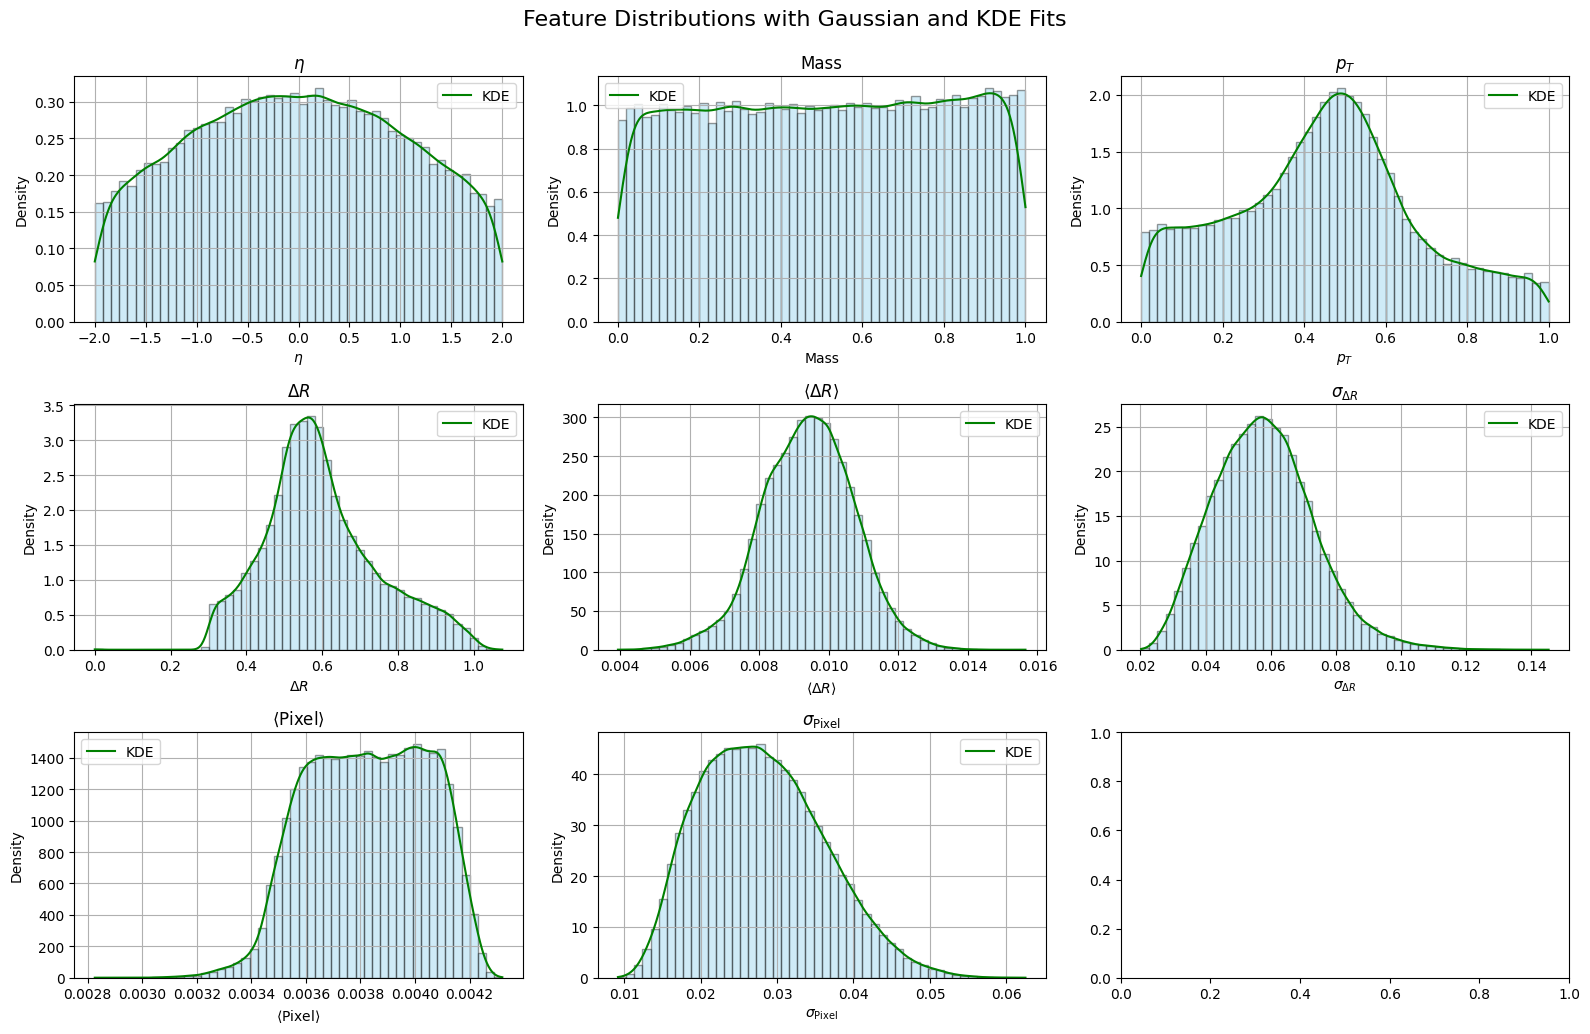

Number of samples: 87266
Image shape: torch.Size([87266, 16, 16])
Feature shape: torch.Size([87266, 9])


In [4]:
batch_size = 128*3
n_events = int(.1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

[Epoch 1/30] [D loss: 0.1265] [G loss: 1.2146] [Validity_loss: 0.5507] 
 [Stat_loss: 0.3132] [NNZ_loss: 0.2507]
Sample feature coding: [0.         1.9799083  0.613428   0.8423176  0.4935447  0.01217522
 0.05637929 0.0041111  0.02625716]


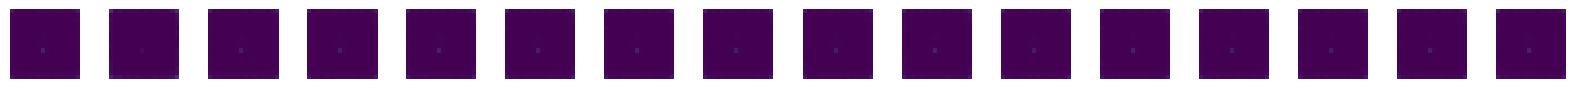

[Epoch 2/30] [D loss: 0.6525] [G loss: 0.4026] [Validity_loss: 0.1193] 
 [Stat_loss: 0.1426] [NNZ_loss: 0.0407]
Sample feature coding: [1.         1.5229017  0.09489842 0.97543687 0.536262   0.00825245
 0.06678763 0.0041456  0.03094206]


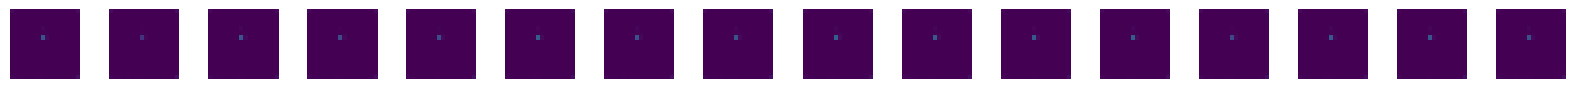

[Epoch 3/30] [D loss: 0.5727] [G loss: 0.3704] [Validity_loss: 0.1460] 
 [Stat_loss: 0.1054] [NNZ_loss: 0.0190]
Sample feature coding: [1.         0.66512805 0.11194855 0.56241685 0.8529347  0.01029859
 0.03055612 0.0037842  0.03832891]


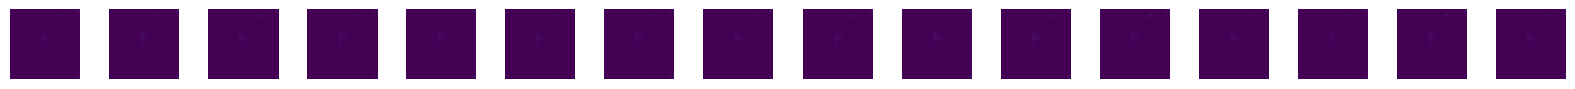

[Epoch 4/30] [D loss: 0.6903] [G loss: 0.3347] [Validity_loss: 0.1068] 
 [Stat_loss: 0.1094] [NNZ_loss: 0.0185]
Sample feature coding: [0.         0.5510219  0.7322651  0.766859   0.63721067 0.01020281
 0.04135477 0.00352348 0.03094473]


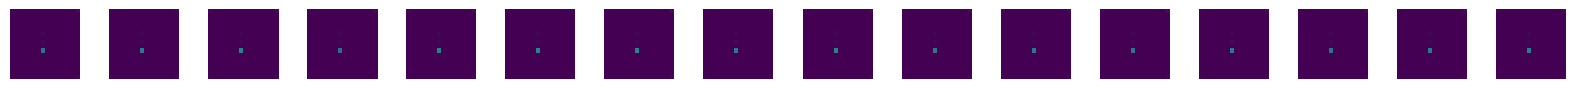

[Epoch 5/30] [D loss: 0.6878] [G loss: 0.2509] [Validity_loss: 0.0924] 
 [Stat_loss: 0.0455] [NNZ_loss: 0.0131]
Sample feature coding: [ 0.         -0.1502384   0.63601243  0.40431678  0.39636043  0.00880027
  0.05924714  0.00368651  0.02574039]


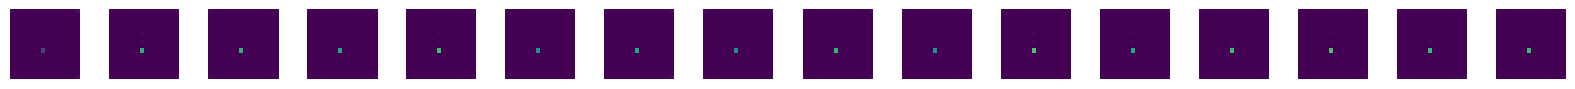

[Epoch 6/30] [D loss: 0.6728] [G loss: 0.2648] [Validity_loss: 0.1036] 
 [Stat_loss: 0.0463] [NNZ_loss: 0.0149]
Sample feature coding: [ 1.         -1.4126608   0.9267325   0.5946043   0.7310708   0.01255433
  0.02806312  0.00405421  0.03970151]


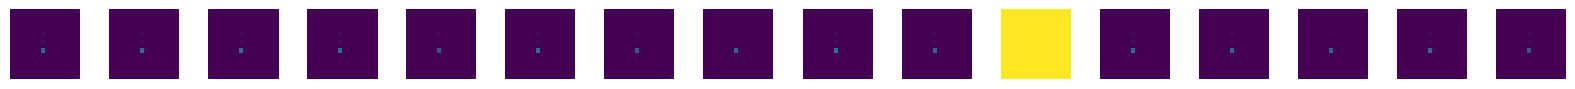

[Epoch 7/30] [D loss: 0.6491] [G loss: 0.2615] [Validity_loss: 0.0998] 
 [Stat_loss: 0.0487] [NNZ_loss: 0.0130]
Sample feature coding: [ 1.         -0.02191582  0.9483568   0.15007496  0.98116815  0.0081452
  0.03858656  0.00365702  0.01955166]


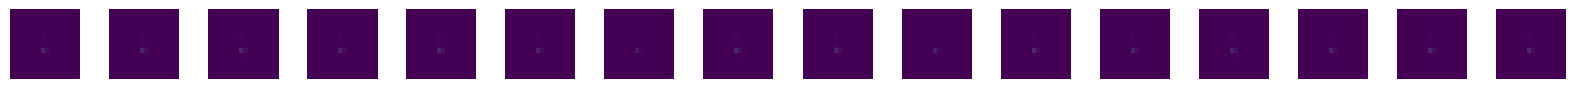

[Epoch 8/30] [D loss: 0.6094] [G loss: 0.3501] [Validity_loss: 0.1243] 
 [Stat_loss: 0.1066] [NNZ_loss: 0.0193]
Sample feature coding: [0.         0.16832776 0.15424356 0.9885632  0.86977243 0.00920375
 0.05575408 0.00364448 0.04319084]


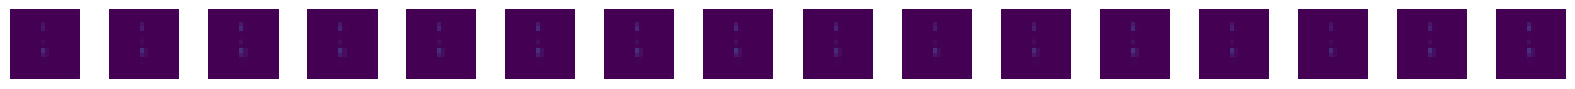

[Epoch 9/30] [D loss: 0.6874] [G loss: 0.3353] [Validity_loss: 0.1121] 
 [Stat_loss: 0.1024] [NNZ_loss: 0.0208]
Sample feature coding: [1.         1.7076423  0.78030896 0.7391946  0.57434446 0.01096415
 0.0689787  0.0036214  0.0360324 ]


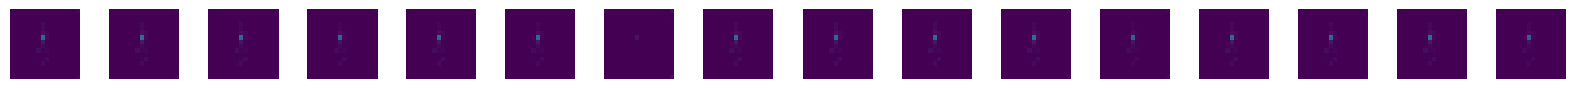

[Epoch 10/30] [D loss: 0.6650] [G loss: 0.4186] [Validity_loss: 0.1312] 
 [Stat_loss: 0.1615] [NNZ_loss: 0.0259]
Sample feature coding: [0.         1.6900653  0.79082507 0.4519135  0.6515424  0.00935248
 0.07336672 0.00378072 0.0431089 ]


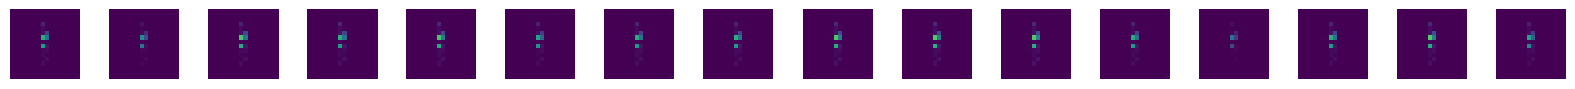

[Epoch 11/30] [D loss: 0.6993] [G loss: 0.3735] [Validity_loss: 0.1186] 
 [Stat_loss: 0.1360] [NNZ_loss: 0.0188]
Sample feature coding: [ 1.         -1.4360343   0.77224725  0.64996666  0.54777586  0.00823674
  0.03169353  0.00389891  0.03524015]


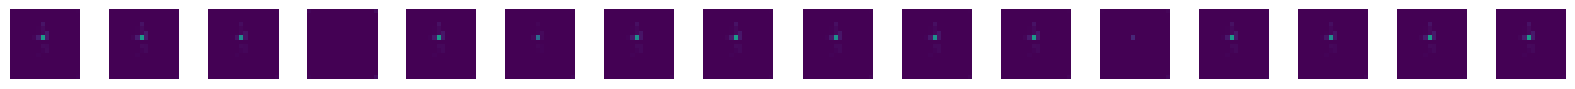

[Epoch 12/30] [D loss: 0.6865] [G loss: 0.4295] [Validity_loss: 0.1474] 
 [Stat_loss: 0.1595] [NNZ_loss: 0.0226]
Sample feature coding: [ 1.         -0.7311301   0.39172626  0.1313151   0.6121321   0.00962337
  0.0763249   0.00362285  0.03505865]


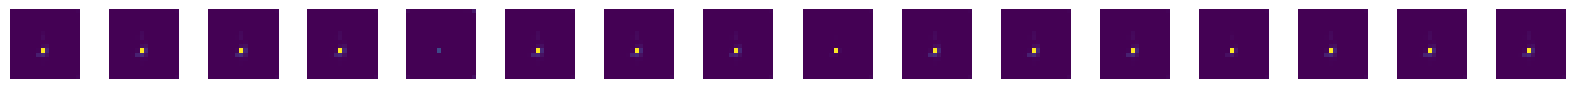

[Epoch 13/30] [D loss: 0.6696] [G loss: 0.2706] [Validity_loss: 0.1154] 
 [Stat_loss: 0.0450] [NNZ_loss: 0.0102]
Sample feature coding: [ 1.         -1.4649556   0.78034246  0.67843884  0.9548123   0.00754817
  0.09588405  0.00396025  0.03006834]


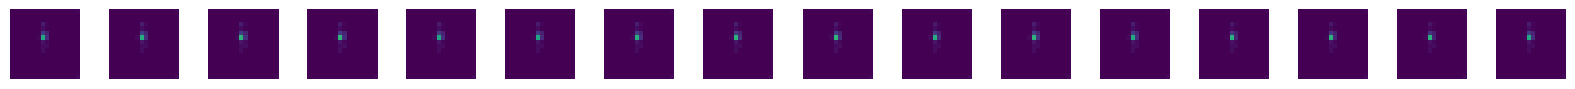

[Epoch 14/30] [D loss: 0.6210] [G loss: 0.2974] [Validity_loss: 0.1314] 
 [Stat_loss: 0.0520] [NNZ_loss: 0.0140]
Sample feature coding: [1.         0.22143312 0.97089064 0.3784933  0.50922644 0.00830089
 0.06067833 0.00387081 0.02625688]


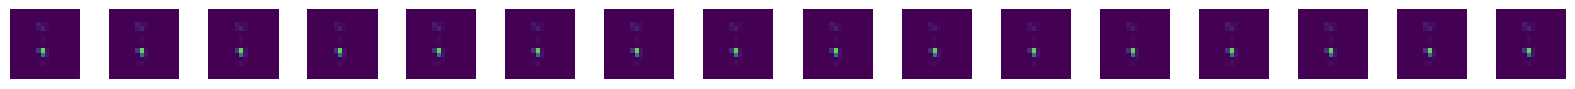

[Epoch 15/30] [D loss: 0.6250] [G loss: 0.4028] [Validity_loss: 0.1535] 
 [Stat_loss: 0.1282] [NNZ_loss: 0.0211]
Sample feature coding: [0.         2.069736   0.05137241 0.08285275 0.6029755  0.00937297
 0.06083117 0.00354974 0.03197709]


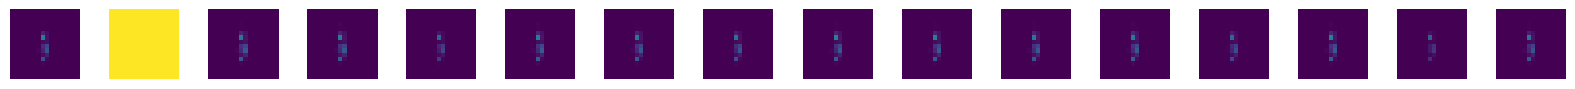

[Epoch 16/30] [D loss: 0.6278] [G loss: 0.2925] [Validity_loss: 0.1323] 
 [Stat_loss: 0.0463] [NNZ_loss: 0.0138]
Sample feature coding: [ 1.          0.12833008 -0.00469876  0.3454264   0.5552566   0.00898522
  0.06958529  0.0040482   0.0304424 ]


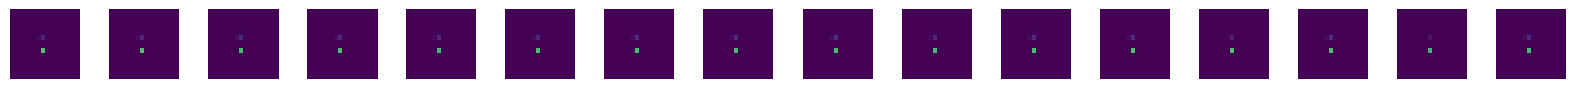

[Epoch 17/30] [D loss: 0.7212] [G loss: 0.2567] [Validity_loss: 0.0956] 
 [Stat_loss: 0.0481] [NNZ_loss: 0.0130]
Sample feature coding: [ 0.         -0.9505852   0.16735771  0.55124396  0.8033375   0.00990541
  0.0421506   0.00370546  0.02245122]


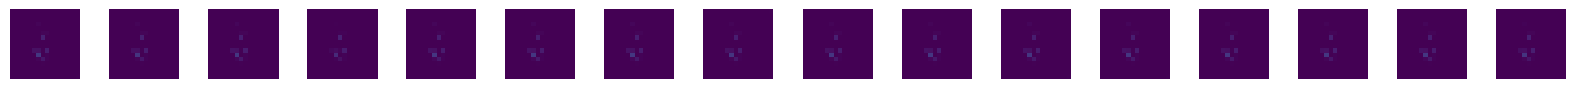

[Epoch 18/30] [D loss: 0.6549] [G loss: 0.3455] [Validity_loss: 0.0953] 
 [Stat_loss: 0.1330] [NNZ_loss: 0.0171]
Sample feature coding: [ 1.         -0.65475076  0.9179755   0.08269666  0.45805028  0.00898597
  0.05486681  0.00365577  0.0335333 ]


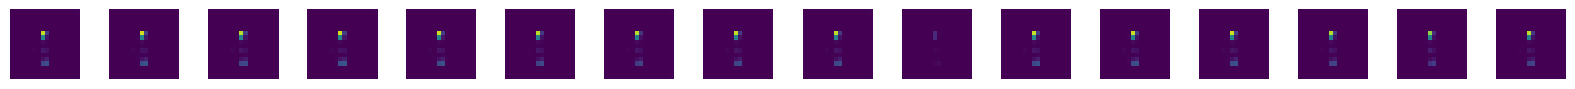

[Epoch 19/30] [D loss: 0.6779] [G loss: 0.3194] [Validity_loss: 0.0923] 
 [Stat_loss: 0.1081] [NNZ_loss: 0.0191]
Sample feature coding: [ 0.          0.5464322   0.07827039 -0.02198234  0.6101871   0.00900975
  0.0445644   0.00394025  0.02436475]


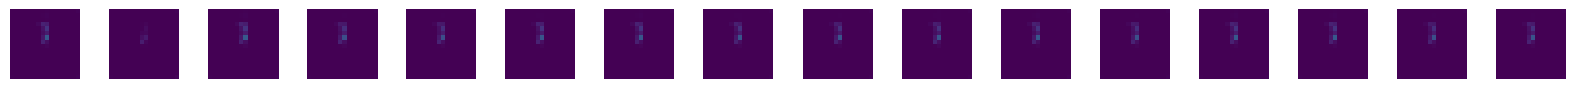

[Epoch 20/30] [D loss: 0.5554] [G loss: 0.3139] [Validity_loss: 0.1572] 
 [Stat_loss: 0.0448] [NNZ_loss: 0.0119]
Sample feature coding: [ 0.         -0.6849547   0.23308791  0.45553878  0.4246095   0.00903515
  0.063406    0.00391264  0.0261861 ]


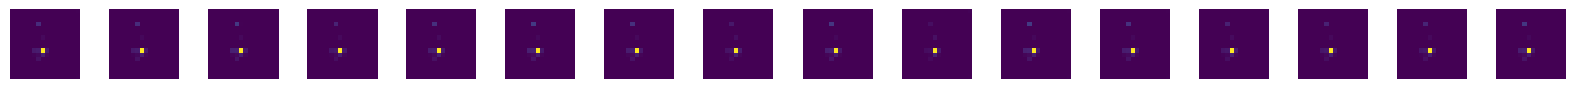

[Epoch 21/30] [D loss: 0.5755] [G loss: 0.3552] [Validity_loss: 0.1458] 
 [Stat_loss: 0.0919] [NNZ_loss: 0.0175]
Sample feature coding: [0.         0.41603118 0.17103705 0.3773622  1.0047022  0.00897421
 0.03865451 0.00354471 0.02564543]


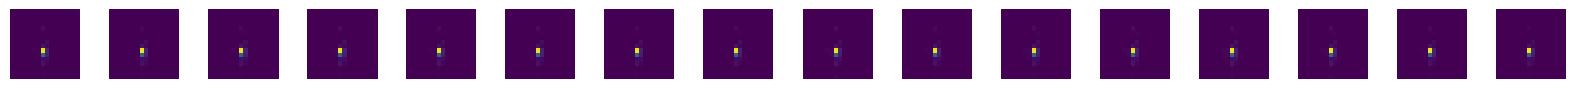

[Epoch 22/30] [D loss: 0.6453] [G loss: 0.2497] [Validity_loss: 0.0934] 
 [Stat_loss: 0.0453] [NNZ_loss: 0.0110]
Sample feature coding: [ 0.         -1.5295992   0.5130304   0.57541317  0.68886584  0.00924859
  0.04751473  0.0039606   0.03113096]


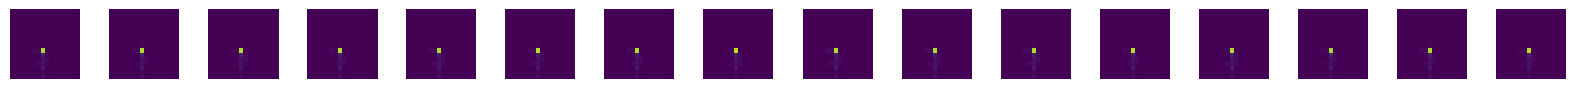

[Epoch 23/30] [D loss: 0.5814] [G loss: 0.4162] [Validity_loss: 0.1575] 
 [Stat_loss: 0.1367] [NNZ_loss: 0.0220]
Sample feature coding: [ 1.         -0.4564522  -0.02546693  0.49710816  0.44841978  0.00846586
  0.06412702  0.00376813  0.03245214]


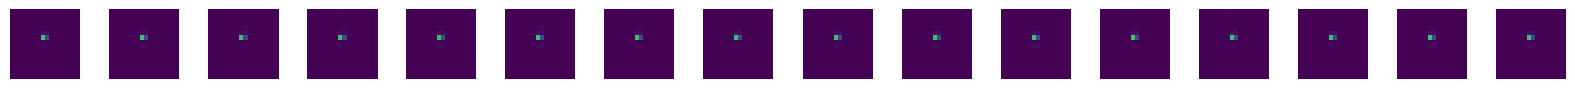

[Epoch 24/30] [D loss: 0.6676] [G loss: 0.3966] [Validity_loss: 0.1269] 
 [Stat_loss: 0.1440] [NNZ_loss: 0.0257]
Sample feature coding: [ 0.         -1.1669492   0.33569655  0.31443897  0.77781457  0.00836474
  0.06259836  0.00350591  0.01593717]


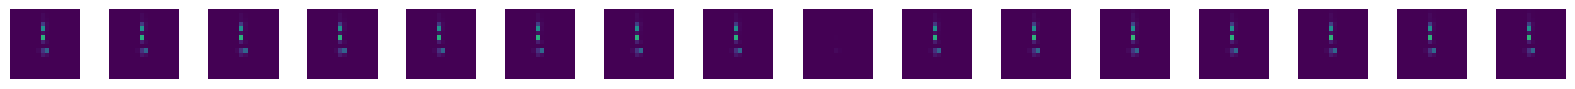

[Epoch 25/30] [D loss: 0.5343] [G loss: 0.3107] [Validity_loss: 0.1473] 
 [Stat_loss: 0.0511] [NNZ_loss: 0.0123]
Sample feature coding: [ 0.         -1.8041767   0.39810118  0.49056363  0.58542854  0.00940468
  0.08767736  0.00410636  0.01917852]


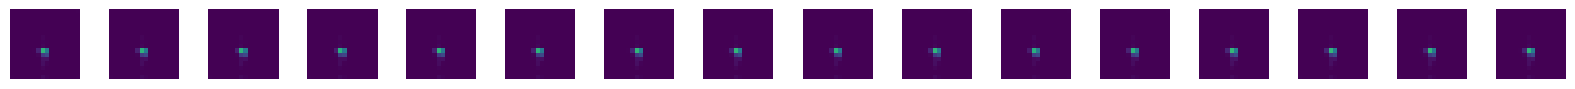

[Epoch 26/30] [D loss: 0.5104] [G loss: 0.3209] [Validity_loss: 0.1576] 
 [Stat_loss: 0.0491] [NNZ_loss: 0.0143]
Sample feature coding: [0.         0.96808183 0.20272706 0.15072867 0.58484644 0.01313856
 0.03631875 0.00375578 0.01965852]


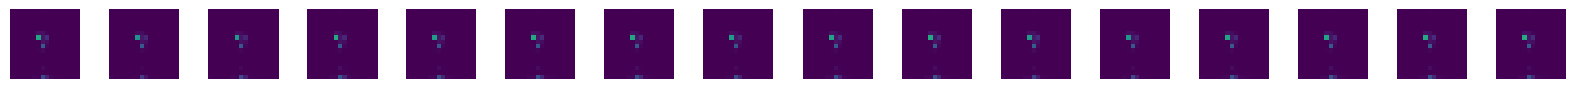

[Epoch 27/30] [D loss: 0.5109] [G loss: 0.4155] [Validity_loss: 0.2055] 
 [Stat_loss: 0.0898] [NNZ_loss: 0.0202]
Sample feature coding: [ 0.         -0.02903405  0.35715553  0.43977147  0.46973887  0.00928876
  0.0825265   0.00387891  0.02718754]


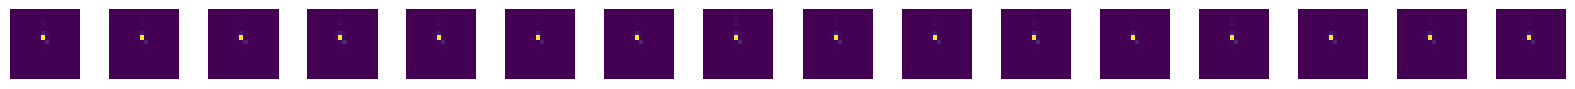

[Epoch 28/30] [D loss: 0.6896] [G loss: 0.3306] [Validity_loss: 0.1217] 
 [Stat_loss: 0.0910] [NNZ_loss: 0.0178]
Sample feature coding: [ 0.         -0.915472    0.03598862  0.3615571   0.6841165   0.00852934
  0.06462373  0.00398505  0.03912064]


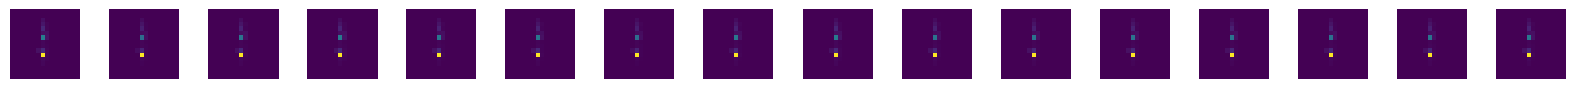

[Epoch 29/30] [D loss: 0.5481] [G loss: 0.4228] [Validity_loss: 0.1777] 
 [Stat_loss: 0.1283] [NNZ_loss: 0.0168]
Sample feature coding: [ 0.         -0.06561665  0.9745411   0.4448531   0.56398386  0.00889303
  0.061585    0.00371451  0.02677661]


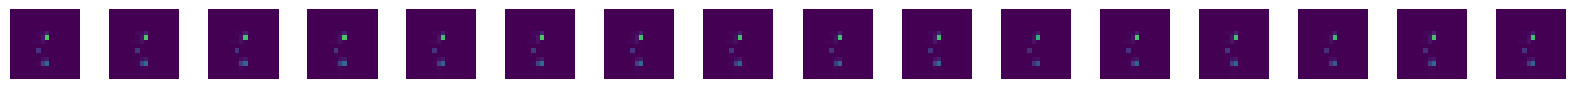

[Epoch 30/30] [D loss: 0.7286] [G loss: 0.2568] [Validity_loss: 0.0993] 
 [Stat_loss: 0.0468] [NNZ_loss: 0.0108]
Sample feature coding: [ 1.         -0.49517193  0.49930236  0.46507052  0.543323    0.01103352
  0.05020868  0.00407447  0.03791439]


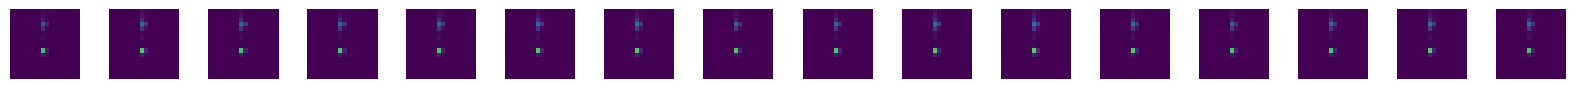

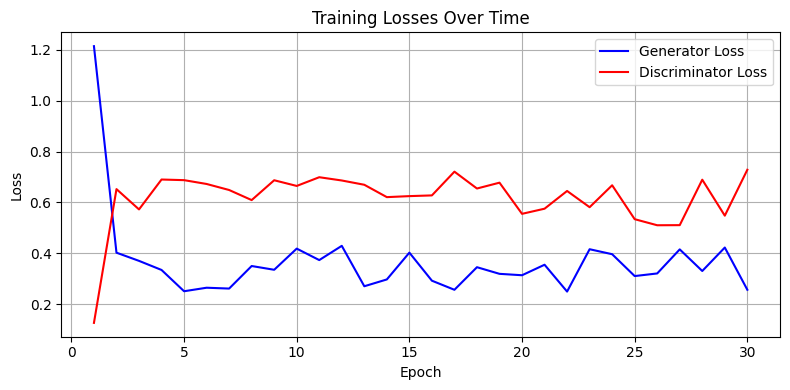

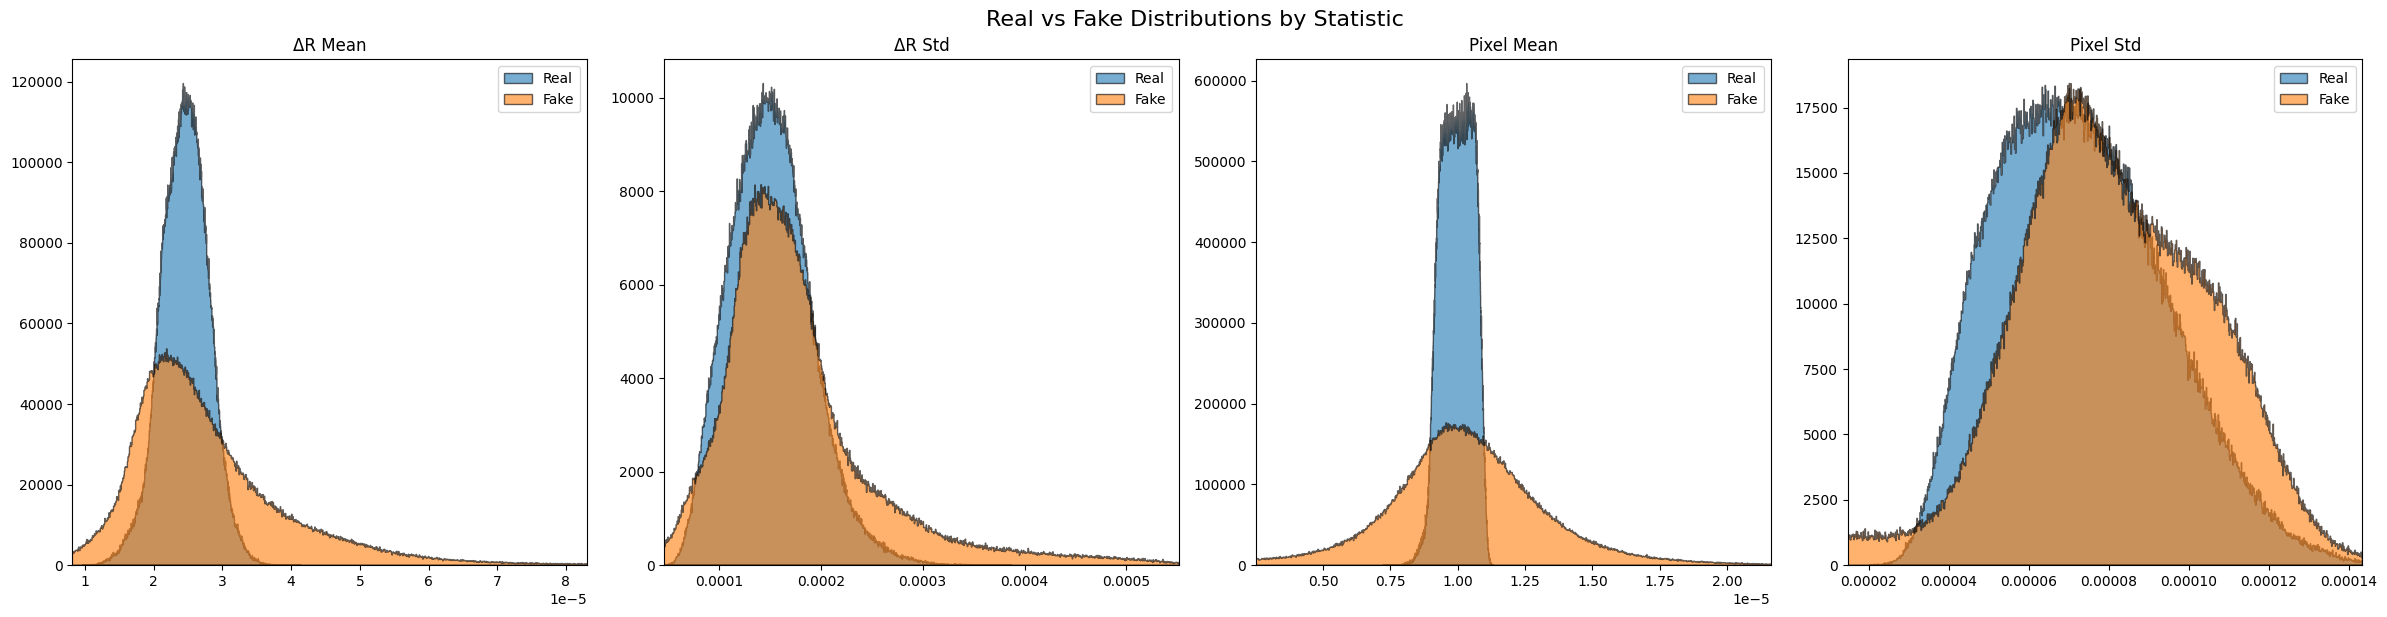

In [5]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

latent_dim = 256
lr = 10e-4
n_epochs = 30
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 2 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .04
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .00006
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .007

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00005
            chi = .001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss) + .1

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

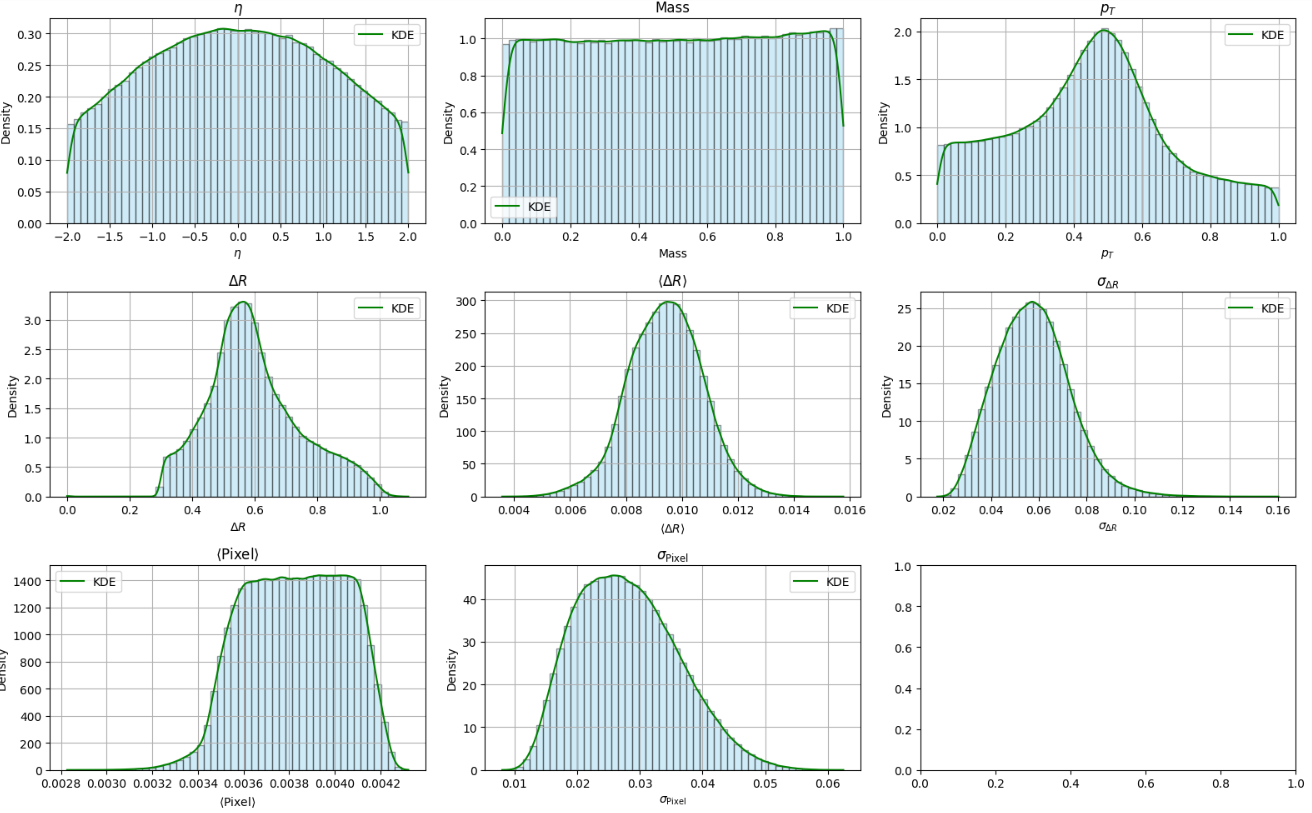

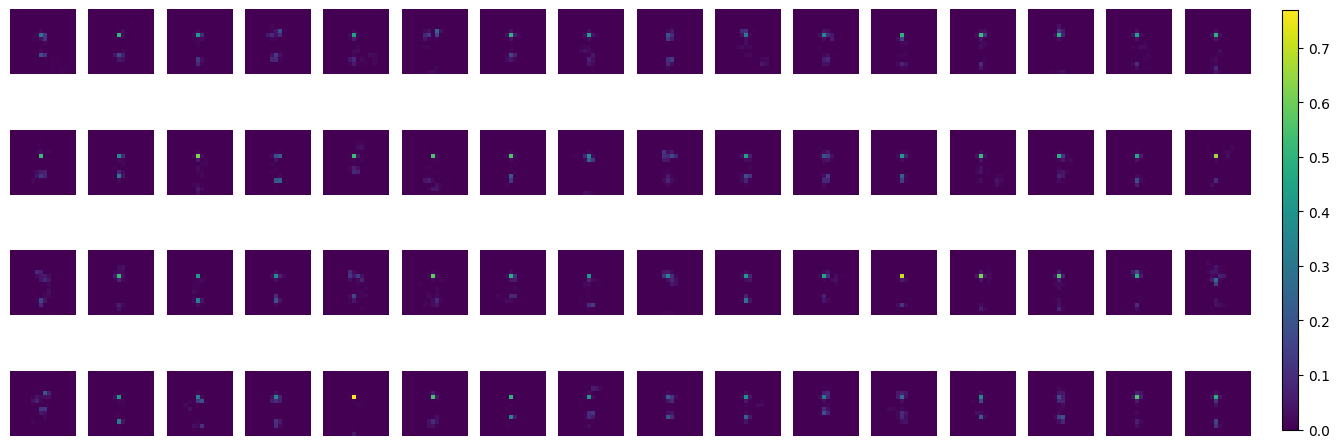

In [6]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [7]:
def test_generated_samples(generator, kdes, batch_size=4, latent_dim=256, codings = None):
    generator.eval()  # Set to eval mode to disable dropout/batchnorm updates

    # Latent vectors
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat = torch.cat([z_codings, z_noise], dim=1)
    z_feat = z_codings

    with torch.no_grad():
        gen_samples = generator(z_feat)

    gen_samples = gen_samples.cpu()
    
    print("Sample feature coding:", z_codings[1].cpu().numpy())

    fig, axes = plt.subplots(1, min(batch_size, 16), figsize=(min(batch_size, 16), 1))
    for i in range(min(batch_size, 16)):
        axes[i].imshow(gen_samples[i, 0].numpy(), cmap= 'viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    generator.train()  # Restore training mode

# add discriminator test for classification, compare label codings for generator

Sample feature coding: [ 0.         -0.16466206  0.97924167  0.31193948  0.9217735   0.00938875
  0.05506201  0.00382487  0.02128344]


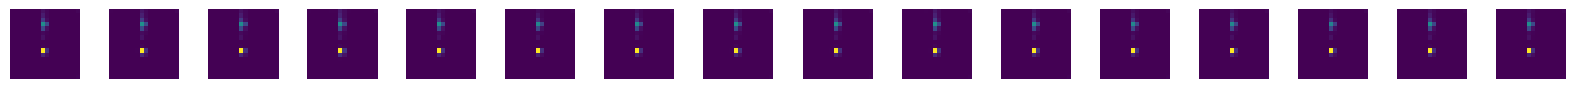

tensor([[-18.0342],
        [  6.7928],
        [  4.4321],
        [  3.1665],
        [  1.0316],
        [-25.7972],
        [ 11.2418],
        [ 11.4245],
        [  3.2191],
        [ -2.4046],
        [ -3.8799],
        [  1.5159],
        [  4.4354],
        [ 17.3929],
        [-18.9507],
        [-19.7391]], device='cuda:0', grad_fn=<MulBackward0>)


In [8]:
# Test discriminator on swapped labels
test_generated_samples(generator, kdes, batch_size=16, latent_dim=256, codings = [0., 1.1214281, 0.7953802, 0.9241728,  0.69733775, 0.0033828, 0.01578446, 0.00170709, 0.02212167])
n=16

pred1 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), dataset.features[:n,:4].cuda())
# print(pred1)
new_dataset = dataset.features[:n,:4].clone()
new_dataset[:n, 0] *= (-2**(new_dataset[:n, 0])+2)

pred2 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), new_dataset[:n,:4].cuda())
# print(pred2)

print((pred1/pred2 - 1)*100)

In [9]:
# Test discriminator on all 1 labels
n_events = 16

real_features = dataset.features[:n_events,:4].clone()
real_imgs = dataset.images[:n_events].clone()
real_labels = real_features[:, 0]

test_features = real_features.clone()
test_labels = torch.tensor(np.zeros_like(n_events))
test_features[:,0] = test_labels
print(test_labels)


pred1 = discriminator(real_imgs.unsqueeze(1).cuda(), test_features.cuda())
pred2 = discriminator(real_imgs.unsqueeze(1).cuda(), real_features.cuda())
print(pred1)
print(pred2)
print(real_labels)
print(test_features[:,0])

tensor(0)
tensor([[0.4476],
        [0.4726],
        [0.5134],
        [0.4879],
        [0.5730],
        [0.4921],
        [0.5221],
        [0.4546],
        [0.3996],
        [0.3976],
        [0.5322],
        [0.4928],
        [0.3984],
        [0.4319],
        [0.5337],
        [0.5071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.3913],
        [0.5414],
        [0.5120],
        [0.4872],
        [0.5019],
        [0.4752],
        [0.5302],
        [0.5080],
        [0.4948],
        [0.5369],
        [0.5305],
        [0.5463],
        [0.5561],
        [0.5359],
        [0.4554],
        [0.4933]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
